In [1]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import copy
import os
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import sys
# 필요한 module import

In [2]:
#Label file:
data_path = 'content/crime16'
classes = os.listdir(data_path)
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]
# classes에 data_path에 저장된 폴더 개수를 저장해주고 decoder는 dictionary형식으로 class 이름에 맞는 label에 숫자를 0~ 붙여준다.
# encoder에는 해당 label에 숫자에 범죄 행위 이름을 붙여준다.

In [3]:
id = list()
path = 'content/crime16'
for i in os.listdir(path):
  p1 = os.path.join(path,i)
  for j in os.listdir(p1):
    p2 = os.path.join(p1,j)
    id.append((i,p2))
# id 리스트에 해당 폴더의 범죄행위이름과 경로정보를 포함한 jpg string data를 저장한다.

In [4]:
class video_dataset(Dataset):
    def __init__(self,frame_list,sequence_length = 16,transform = None):
        self.frame_list = frame_list
        # 범죄 이름과 해당 jpg string data가 저장된 list를 받아온다.
        self.transform = transform
        # image를 transform해서 저장할때 필요한 인자들 저장 (어떻게 transform할 것인지) 
        self.sequence_length = sequence_length
        # 몇개로 구성된 image인지 저장
    def __len__(self):
        return len(self.frame_list)
        # 총 몇개의 data를 훈련시키는지 출력
    def __getitem__(self,idx):
        label,path = self.frame_list[idx]
        # label과 path 정보를 self.frame_list로부터 받아온다.
        img = cv2.imread(path)
        # 해당 path에 image를 받아온다.
        seq_img = list()
        for i in range(16):
            # 총 32개의 image를 train
          img1 = img[:,128*i:128*(i+1),:]
            # img1에 img에 저장된 16개의 image들을 1개씩 받아온다.
          if(self.transform):
            img1 = self.transform(img1)
            # img1을 self.transform에 저장된 인자값들로 변환시킨다.
          seq_img.append(img1)
        # 변환된 img1을 다시 seq_img 리스트에 저장
        seq_image = torch.stack(seq_img)
        # torch data로 저장 (stack을 통해서 1차원을 늘려준다. seq_img data를 1개씩 쌓아서 저장한다.)
        seq_image = seq_image.reshape(3,16,im_size,im_size)
        # seq_image의 shape를 3, 16, 128, 128로 바꾼다.
        return seq_image,decoder[label]
    # seq_image와 해당 label의 숫자값을 return

In [5]:
im_size = 128
mean = [0.4889, 0.4887, 0.4891]
std = [0.2074, 0.2074, 0.2074]
# image size는 128x128
# normalize 값을 지정

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
# PIL image로 변환시키고 128x128로 크기 변경, random하게 좌우반전, 10도씩 random하게 image 회전, tensor로 바꾸고 normalize 적용
train_data = video_dataset(id,sequence_length = 16,transform = train_transforms)
# train_data 객체 생성
train_loader = DataLoader(train_data,batch_size = 1
                          ,num_workers = 0 ,shuffle = True)
# batch_size는 10, num_workers는 병렬 연결 0으로 하고 shuffle로 data 섞기
dataloaders = {'train':train_loader}
# dataloaders에 train_loader 저장

In [6]:
from model import resnet50
model = resnet50(class_num=8)
# model.py에서 resnet50 model을 받아온다. (slowfast 모델)
# class 개수는 8개, cuda로 변환

In [7]:
from clr import *
cls_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9,weight_decay = 1e-4)
num_epochs = 30
onecyc = OneCycle(len(train_loader)*num_epochs,1e-3)
# onecycle 방법을 통해서 learning_rate와 momentum, weight_deacy값을 계속 수정시킨다.

In [8]:
os.makedirs('content/weights_crime_16',exist_ok = True)
from torch.autograd import Variable
iteration = 0
acc_all = list()
loss_all = list()
    
for epoch in range(num_epochs):
    print('')
    print(f"--- Epoch {epoch} ---")
    phase1 = dataloaders.keys()
    # phase1에 train_loaders 저장
    for phase in phase1:
        print('')
        print(f"--- Phase {phase} ---")
        epoch_metrics = {"loss": [], "acc": []}
        '''print("phase: ", phase)
        print("dataloaders[phase] : ", dataloaders[phase])'''
        for batch_i, (X, y) in enumerate(dataloaders[phase]):
            #iteration = iteration+1
            image_sequences = Variable(X, requires_grad=True)
            # Variable 변수 image_sequences 선언
            labels = Variable(y, requires_grad=False)
            # Variable 변수 labels 선언
            optimizer.zero_grad()
            # gradient descent 직전에 초기화 해주기.
            #model.lstm.reset_hidden_state()
            predictions = model(image_sequences)
            # model을 통과시킨 예측값을 predictions에 저장
            loss = cls_criterion(predictions, labels)
            # loss값은 one_cycle 방식을 통해서 예측값과 label값으로 계산
            acc = 100 * (predictions.detach().argmax(1) == labels).cpu().numpy().mean()
            # accuracy 값은 predictions 계산을 잠깐 멈추고 해당 label 10개에 몇 개의 data가 정확한지 계산 
            loss.backward()
            # loss값을 통해 back propagation
            optimizer.step()
            # optimizer 값 갱신
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)
            # epoch metrics에 저장
            if(phase=='train'):
                lr,mom = onecyc.calc()
                update_lr(optimizer, lr)
                update_mom(optimizer, mom)
                # learning_rate와 momentum을 갱신
            batches_done = epoch * len(dataloaders[phase]) + batch_i
            # 진행한 batch 개수
            batches_left = num_epochs * len(dataloaders[phase]) - batches_done
            # 남은 batch 개수
            sys.stdout.write(
                    "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                    % (
                        epoch,
                        num_epochs,
                        batch_i,
                        len(dataloaders[phase]),
                        loss.item(),
                        np.mean(epoch_metrics["loss"]),
                        acc,
                        np.mean(epoch_metrics["acc"]),
                    )
                )

                # Empty cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
        print('')
        print('{} , acc: {}'.format(phase,np.mean(epoch_metrics["acc"])))
        torch.save(model.state_dict(),'content/weights_crime/c3d_{}.h5'.format(epoch))
        if(phase=='train'):
          acc_all.append(np.mean(epoch_metrics["acc"]))
          loss_all.append(np.mean(epoch_metrics["loss"]))


--- Epoch 0 ---

--- Phase train ---
[Epoch 0/30] [Batch 5839/5840] [Loss: 1.880917 (3.269508), Acc: 0.00% (16.18%)])]
train , acc: 16.181506849315067

--- Epoch 1 ---

--- Phase train ---
[Epoch 1/30] [Batch 5839/5840] [Loss: 2.461759 (2.681403), Acc: 0.00% (17.24%)])]
train , acc: 17.243150684931507

--- Epoch 2 ---

--- Phase train ---
[Epoch 2/30] [Batch 5839/5840] [Loss: 3.012767 (2.433183), Acc: 0.00% (18.80%)])]
train , acc: 18.801369863013697

--- Epoch 3 ---

--- Phase train ---
[Epoch 3/30] [Batch 5839/5840] [Loss: 3.208664 (2.264793), Acc: 0.00% (22.65%)])]
train , acc: 22.654109589041095

--- Epoch 4 ---

--- Phase train ---
[Epoch 4/30] [Batch 5839/5840] [Loss: 1.882558 (2.241064), Acc: 0.00% (21.59%)])]
train , acc: 21.59246575342466

--- Epoch 5 ---

--- Phase train ---
[Epoch 5/30] [Batch 5839/5840] [Loss: 0.614110 (2.147078), Acc: 100.00% (24.73%)]
train , acc: 24.726027397260275

--- Epoch 6 ---

--- Phase train ---
[Epoch 6/30] [Batch 5839/5840] [Loss: 0.969717 (2.1

In [9]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()
def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

In [10]:
loss_all

[3.2695082283453525,
 2.681403369305987,
 2.433182746297616,
 2.26479323925578,
 2.2410643723691264,
 2.1470780482196745,
 2.12135764951116,
 2.060689701110584,
 2.009497704674579,
 1.9725051668475777,
 1.8982560078278568,
 1.8050321176637774,
 1.7266945974627823,
 1.6411778164980055,
 1.5656462010552736,
 1.3698265745728924,
 1.238466940185634,
 1.0878700755836814,
 0.9277025095712667,
 0.7691778068666356,
 0.6616386780781235,
 0.5098160772815366,
 0.3631345968361648,
 0.2881314122895199,
 0.18530446795125016,
 0.13429198603960354,
 0.0642286332312548,
 0.049239739356185,
 0.03743541394451469,
 0.03275964578302866]

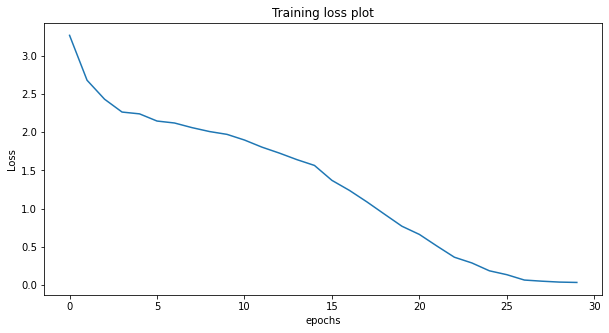

In [11]:
error_plot(loss_all)

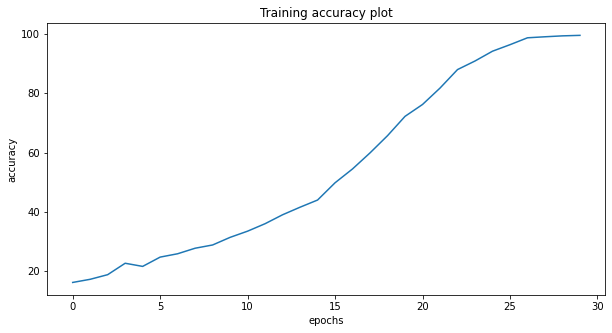

In [12]:
acc_plot(acc_all)